In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gen_prefs_mat(n):
    u = np.zeros((n,n))
    for i in range(n):
        u[i, ] = np.random.permutation(range(n))
    return u

def gen_prefs_v(v_mat, n, k):
    v = np.zeros((n, k))
    choice_sets = np.zeros((n, k))
    for i in range(k):
        choice_sets[:,i] = np.random.permutation(range(n))
    for i in range(n):
        k_ind = 0
        for j in range(n):
            if v_mat[i][j] in choice_sets[i,]:
                v[i, k_ind] = v_mat[i][j]
                k_ind += 1
    return v

def gen_prefs_u(u):
    d = dict()
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            if not i in d:
                d[i] = dict()
            d[i][u[i,j]] = j
    return d

# Goal: under random matchings-based choice sets, is there a curse of k>=2 choices?
def jobs_propose(u_dict, v_mat, k):
    """ u is the dict of preferences of candidates, v is preferences of firms """
    n = len(v_mat)
    v_match = np.array([-1] * n)
    u_match = np.array([-1] * n)
    next_proposal_ind = np.array([0] * n)
    # while all the people who are unmatched have someone left to propose to
    while True:
        unmatched = v_match == -1
        more_proposees = next_proposal_ind != k
        if not np.any(unmatched & more_proposees):
            break
        # iterate over jobs
        for i in range(n):
            if v_match[i] != -1:
                continue
            # iterate through their preferences
            for j in range(next_proposal_ind[i], k):
                proposee = int(v_mat[i][j])
                next_proposal_ind[i] = j
                if u_match[proposee] == -1:
                    u_match[proposee] = i
                    v_match[i] = proposee
                    break
                elif (u_dict[proposee][i] < u_dict[proposee][u_match[proposee]]):
                    rejectee = u_match[proposee]
                    u_match[proposee] = i
                    v_match[i] = proposee
                    v_match[rejectee] = -1
                    break
                if j == k-1:
                    next_proposal_ind[i] = k
                
    return u_match, v_match
            


In [31]:
def sample_match_val(n, k, unmatched_cost):
    u_mat = gen_prefs_mat(n)
    u_dict = gen_prefs_u(u_mat)
    v_mat = gen_prefs_mat(n)
    v_prefs = gen_prefs_v(v_mat, n, k)
    v_dict = gen_prefs_u(v_mat)
    
    u_match, v_match = jobs_propose(u_dict, v_prefs, k)
    v_ranks = np.array([v_dict[i][int(j)] if j != -1 else unmatched_cost for i, j in enumerate(v_match)])
    avg_match_val = np.mean(n - v_ranks)
    return avg_match_val

def plot_sims(unmatched_cost):
    sims = np.zeros((N, K))
    for k in range(1, K):
        sims[:,k-1] = [sample_match_val(n, k, unmatched_cost)/(n+1) for _ in range(N)]
    avgs = [np.mean(sims[:,k]) for k in range(K-1)]
    sds = [np.std(sims[:,k])/np.sqrt(n+1) for k in range(K-1)]
    fig, ax = plt.subplots()
    ax.errorbar(range(1, K), avgs, yerr=sds)
    ax.set_xlabel("Max choice set size (k)")
    ax.set_ylabel("Average match value")
    

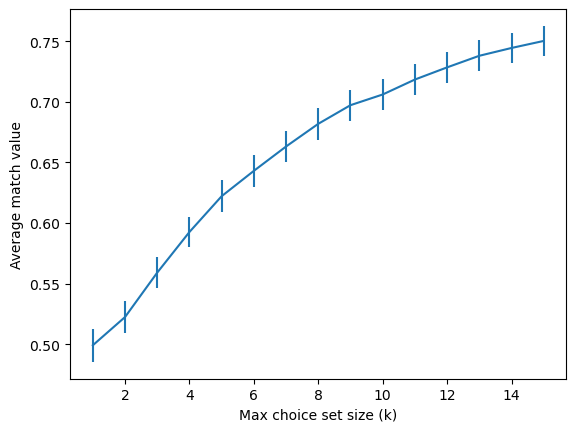

In [32]:
n = 19
N = 1000
K = 16

plot_sims(n)

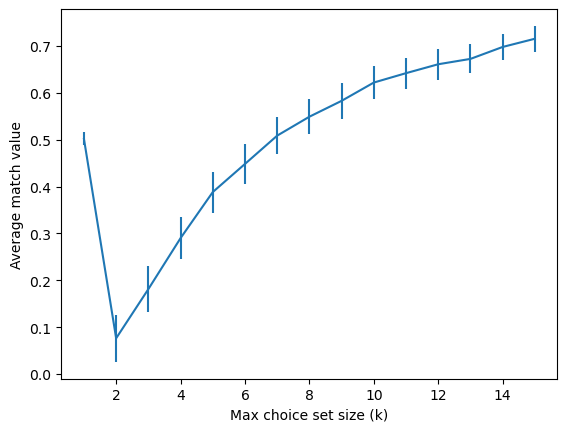

In [33]:
n = 19
N = 1000
K = 16

plot_sims(6*n)

In [11]:
n = 9
k = 1

u_mat = gen_prefs_mat(n)
u_dict = gen_prefs_u(u_mat)
v_mat = gen_prefs_mat(n)
v_prefs = gen_prefs_v(v_mat, n, k)

u_match, v_match = jobs_propose(u_dict, v_prefs, k)
np.mean(n - v_match)

5.0

In [5]:
n = 9

u_mat = gen_prefs_mat(n)
u_dict = gen_prefs_u(u_mat)
v_mat = gen_prefs_mat(n)

u_match, v_match = jobs_propose(u_dict, v_mat, n)
np.mean(n - v_match)


5.0